YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


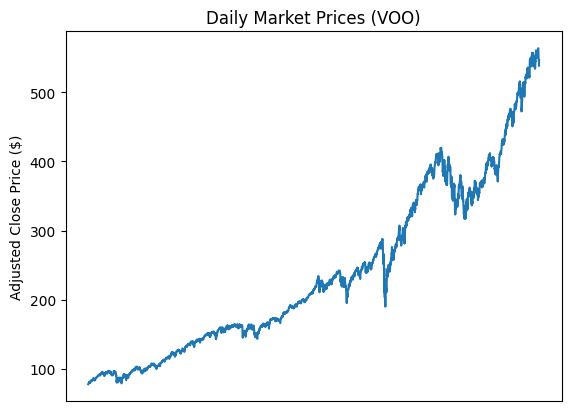

In [1]:
from lbm.datasets.voo import ClosePricesPreprocessor
from matplotlib import pyplot as plt

processor1 = ClosePricesPreprocessor(lookback=1)
train_loader, val_loader, test_loader = processor1.get_loaders()

prices = processor1.dataset.x
plt.plot(prices)
plt.title("Daily Market Prices (VOO)")
# turn off labels on x-axis
plt.ylabel("Adjusted Close Price ($)")
plt.xticks([])
plt.show()

In [2]:
from torch.optim import Adam
from torch.nn import MSELoss
from lbm.workflow import train_and_validate
from lbm.workflow.price_forecasts import directional_accuracy, return_error
from lbm.devices import get_device
import numpy as np
import torch
import warnings
from torch import nn

warnings.simplefilter('error')

device = get_device()

def validate_model(model, preprocessor, epochs=50):
    train_loader, val_loader, _ = preprocessor.get_loaders()
    optimizer = Adam(model.parameters())
    loss_fn = MSELoss()
    train_losses, val_losses = train_and_validate(model, train_loader, 
                                                  val_loader, optimizer, 
                                                  loss_fn, epochs=epochs,
                                                  device=device)
    plt.plot(np.arange(1, len(train_losses) + 1), np.sqrt(train_losses), 
             label='Training', color='blue')
    plt.plot(np.arange(1, len(val_losses) + 1), np.sqrt(val_losses),
             label='Validation', color='orange')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('$\\sqrt{MSE Loss}$ (Dollars)')
    plt.show()
    # Switch the model to evaluation mode
    model.eval()

    all_predictions = []
    all_targets = []
    # Disable gradient calculation
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            # Forward pass: get model predictions
            preds = model(x_val)
            
            # Collect the predictions and actuals
            all_predictions.append(preds)
            all_targets.append(y_val)

    # Concatenate the batched tensors
    all_predictions = torch.cat(all_predictions).cpu().numpy()
    all_targets = torch.cat(all_targets).cpu().numpy()

    # Plot as two time-series curves on the same plot
    plt.plot(all_predictions, label="Predicted")
    plt.plot(all_targets, label="Actual")

    plt.title("Predicted vs. Actual Over Time (Validation)")
    plt.xlabel("Time Index (sorted)")
    plt.ylabel("Value")
    plt.legend()
    plt.show()


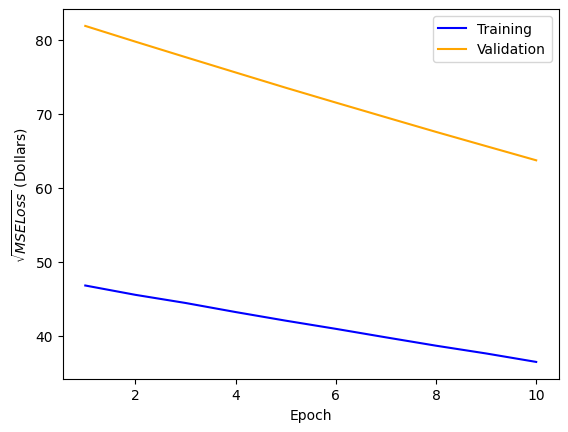

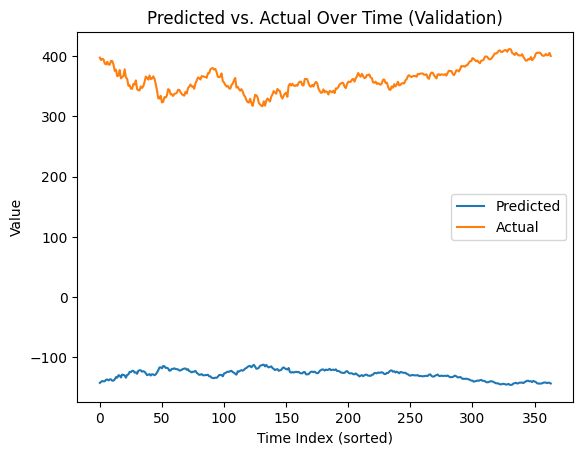

In [3]:
class LinearOneItemForecaster(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(1, 1)

    def forward(self, x):
        x = x.squeeze(2)
        x = self.linear(x)
        x = x.squeeze(1)
        return x

model = LinearOneItemForecaster()

validate_model(model, processor1, epochs=10)

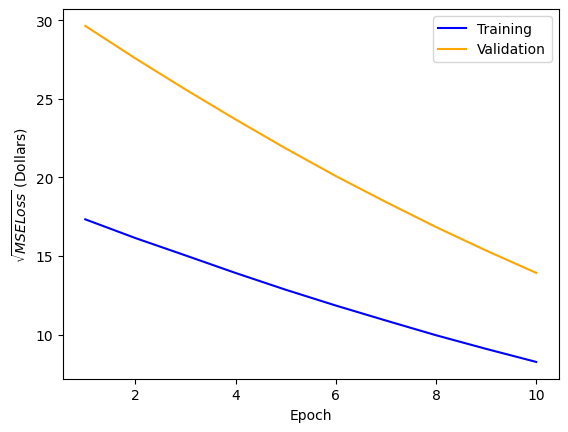

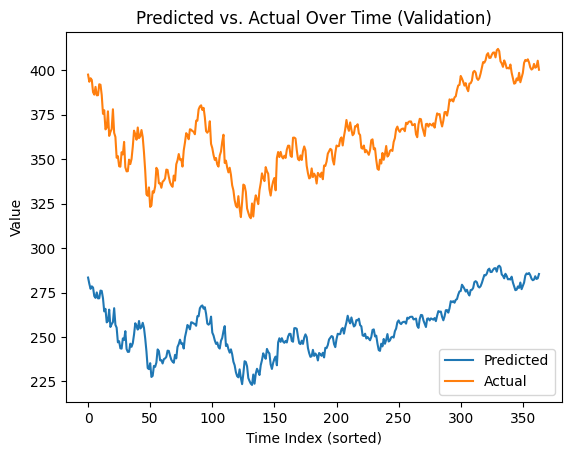

In [4]:
class NoBiasLinearForecaster(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(1, 1, bias=False)

    def forward(self, x):
        x = x.squeeze(2)
        x = self.linear(x)
        x = x.squeeze(1)
        return x

model = NoBiasLinearForecaster()

validate_model(model, processor1, epochs=10)

[*********************100%***********************]  1 of 1 completed

Mean returns: 0.06%
Standard deviation of returns: 1.07%


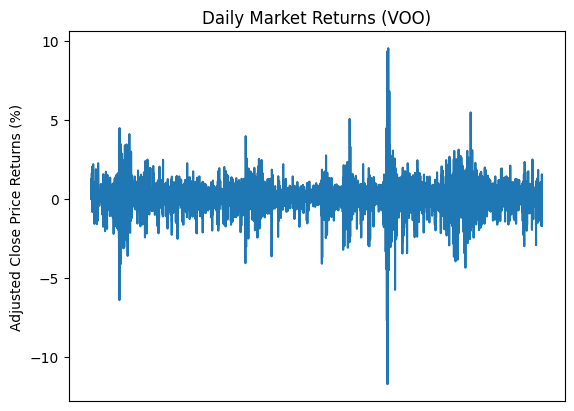

In [13]:
from lbm.datasets.voo import ReturnsPreprocessor

retrurns_processor1 = ReturnsPreprocessor(lookback=1)
train_loader, val_loader, test_loader = processor1.get_loaders()

prices = retrurns_processor1.dataset.returns
plt.plot(prices * 100.0)
plt.title("Daily Market Returns (VOO)")
# turn off labels on x-axis
plt.ylabel("Adjusted Close Price Returns (%)")
plt.xticks([])

print(f"Mean returns: {torch.mean(prices).item() * 100.0:.2f}%")
print(f"Standard deviation of returns: {torch.std(prices).item() * 100.0:.2f}%")

In [16]:
import matplotlib.ticker as mtick

def validate_returns_model(model, preprocessor, epochs=50):
    batch_size = 64
    train_loader, val_loader, _ = preprocessor.get_loaders(batch_size=batch_size)
    optimizer = Adam(model.parameters())
    loss_fn = MSELoss()
    train_losses, val_losses = train_and_validate(model, train_loader, 
                                                  val_loader, optimizer, 
                                                  loss_fn, epochs=epochs,
                                                  device=device)
    _, ax = plt.subplots()
    ax.plot(np.arange(1, len(train_losses) + 1), np.sqrt(train_losses), 
            label='Training', color='blue')
    ax.plot(np.arange(1, len(val_losses) + 1), np.sqrt(val_losses),
            label='Validation', color='orange')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('$\\sqrt{MSE Loss}$ (%)')
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))  # 1.0 means values are in decimal format (e.g., 0.02 -> 2%)
    plt.show()
    # Switch the model to evaluation mode
    model.eval()

    all_predictions = []
    all_targets = []
    # Disable gradient calculation
    with torch.no_grad():
        for batch_index, (x_val, y_val) in enumerate(val_loader):
            x_val, y_val = x_val.to(device), y_val.to(device)
            # Forward pass: get model predictions
            preds = model(x_val)
            
            count = x_val.size()[0]
            x, y = preprocessor.get_val_prices(batch_index, batch_size, count)
            x, actual = x.to(device), y.to(device)
            prediction = x * (preds + 1.0)

            # Collect the predictions and actuals
            all_predictions.append(prediction)
            all_targets.append(actual)

    # Concatenate the batched tensors
    all_predictions = torch.cat(all_predictions).cpu().numpy()
    all_targets = torch.cat(all_targets).cpu().numpy()

    # Plot as two time-series curves on the same plot
    plt.plot(all_predictions, label="Predicted")
    plt.plot(all_targets, label="Actual")

    plt.title("Predicted vs. Actual Over Time (Validation)")
    plt.xlabel("Time Index (sorted)")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

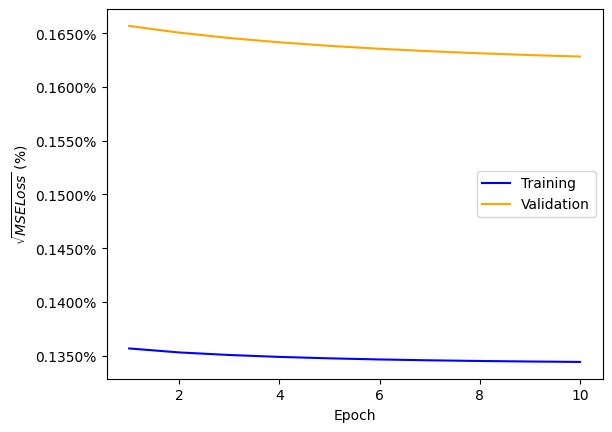

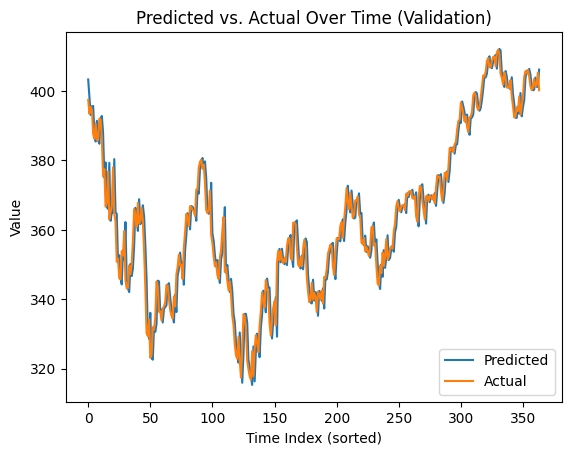

In [18]:
model = NoBiasLinearForecaster()

validate_returns_model(model, retrurns_processor1, epochs=10)